<h1>CD3 Population</h1>

In [24]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from datetime import datetime
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
test_init()

In [3]:
def visualise_manual_threshold(sample_go, parent_population, x, t, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data['SSC-A'], bins=500, norm=LogNorm())
    ax.axvline(t, c='r')
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [4]:
def visualise_manual_rect(sample_go, parent_population, x, y, x_min, x_max, y_min, y_max, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x, y], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    r = Rectangle(xy=(x_min, y_min), width=x_max, height=y_max, fill=False, edgecolor='r')
    ax.add_patch(r)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

<h2>Manual Gating</h2>

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [4]:
samples = exp.list_samples()
samples = [x for x in samples if x != 'sep6']

In [12]:
for x in samples:
    hc = Gating(exp, x)
    remove = [_ for _ in hc.populations.keys() if 'liveCD3' in _]
    for r in remove:
        hc.populations.pop(r)
    hc.gates = dict()
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [87]:
hc = Gating(exp, 'hc19')

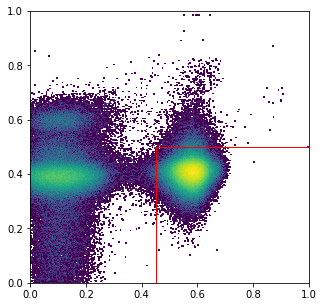

In [88]:
x_min, x_max, y_min, y_max = 0.45, 1.0, 0, 0.5
visualise_manual_rect(hc, 'lymphocytes', 'CD3', 'L/D', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1))

In [89]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_liveCD3', definition='+')
child_populations.add_population('manual_liveCD3_Neg', definition='-')

gate_definition = dict(x='CD3', y='L/D', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_liveCD3', parent='lymphocytes', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

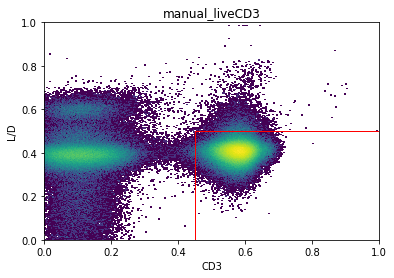

In [90]:
hc.apply('manual_liveCD3')

In [91]:
hc.save(overwrite=True)

Saved successfully!


True

<h1>Testing automated gates</h1>

In [114]:
import os
if os.path.isfile('cd3live_performance.csv'):
    x = pd.read_csv('cd3live_performance.csv')
    gating_performance = x.to_dict('list')
else:
    gating_performance = dict(sample_id=[], method=[], time=[],
                             f1_score=[], accuracy=[], precision=[],
                             recall=[], FPR=[])

def audited_apply(sample_go, gate_name, manual_pop, save=True, plot=True):
    # Apply function and measure time taken
    start = datetime.now()
    sample_go.apply(gate_name=gate_name, plot_output=plot)
    end = datetime.now()
    gating_performance['sample_id'].append(sample_go.id)
    gating_performance['method'].append(gate_name)
    gating_performance['time'].append((end-start).total_seconds())
    
    # Rate performance of result
    parent = sample_go.get_population_df(sample_go.populations[manual_pop].parent.name).copy()
    manual_pop_idx = sample_go.populations[manual_pop].index
    auto_pop_idx = sample_go.populations[gate_name].index
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop_idx), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(auto_pop_idx), 1)
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    gating_performance['f1_score'].append(f1)
    gating_performance['accuracy'].append(accuracy)
    gating_performance['precision'].append(precision)
    gating_performance['recall'].append(recall)
    tn, fp, fn, tp = confusion_matrix(y_pred=parent['auto'], y_true=parent['manual']).ravel()
    gating_performance['FPR'].append(fp/(fp+tn))
    df = pd.DataFrame(gating_performance)
    if save:
        df.to_csv('cd3live_performance.csv', index=False)
    return df[df.sample_id == sample_go.id]

def remove_result(method, gating_performance):
    df = pd.DataFrame(gating_performance)
    df = df[df['method'] != method]
    gating_performance = df.to_dict('list')
    return gating_performance

In [98]:
hc = Gating(exp, 'hc1')

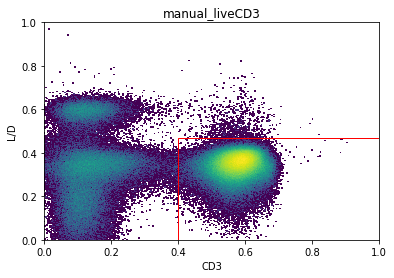

In [99]:
hc.plotting.plot_gate('manual_liveCD3')

In [100]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('gmm_liveCD3', definition='+')
child_populations.add_population('gmm_liveCD3_NEG', definition='-')
gate_definition = dict(x='CD3', y='L/D', target=(0.6, 0.4), k=3, conf=0.99)
hc.create_gate(gate_name='gmm_liveCD3', parent='lymphocytes', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,time,f1_score,accuracy,precision,recall,FPR
0,hc1,gmm_liveCD3,2.553504,0.986595,0.979638,0.999899,0.97364,0.000328


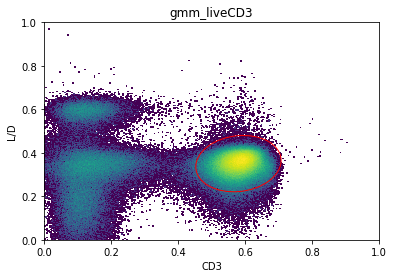

In [101]:
audited_apply(hc, 'gmm_liveCD3', 'manual_liveCD3', save=False)

In [102]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_liveCD3', target=(0.6, 0.4), weight=1)
gate_definition = dict(x='CD3', y='L/D', min_pop_size=100, distance_nn=0.01, frac=0.05,nn=10)
hc.create_gate(gate_name='dbscan_liveCD3', parent='lymphocytes', class_='DensityBasedClustering', method='dbscan',
                kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,time,f1_score,accuracy,precision,recall,FPR
0,hc1,gmm_liveCD3,2.553504,0.986595,0.979638,0.999899,0.973640,0.000328
1,hc1,dbscan_liveCD3,3.911153,0.950786,0.927804,1.000000,0.906189,0.000000


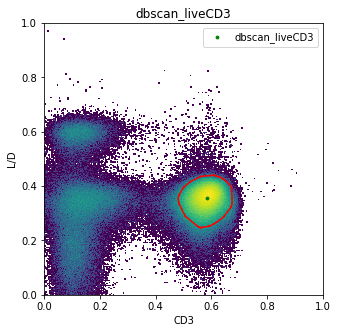

In [103]:
audited_apply(hc, 'dbscan_liveCD3', 'manual_liveCD3', save=False)

In [104]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_liveCD3', target=(0.6, 0.4), weight=1)
gate_definition = dict(x='CD3', y='L/D', min_pop_size=100, frac=0.05)
hc.create_gate(gate_name='hdbscan_liveCD3', parent='lymphocytes', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,time,f1_score,accuracy,precision,recall,FPR
0,hc1,gmm_liveCD3,2.553504,0.986595,0.979638,0.999899,0.973640,0.000328
1,hc1,dbscan_liveCD3,3.911153,0.950786,0.927804,1.000000,0.906189,0.000000
2,hc1,hdbscan_liveCD3,47.749728,0.997968,0.996872,0.997715,0.998221,0.007636


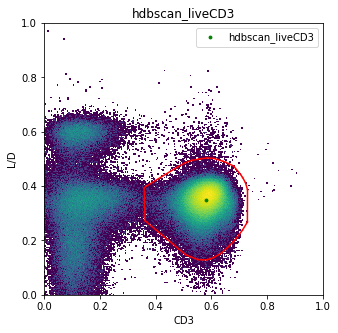

In [105]:
audited_apply(hc, 'hdbscan_liveCD3', 'manual_liveCD3', save=False)

In [106]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_liveCD3', definition=['+-'])
child_populations.add_population('dens2d_liveCD3_Neg', definition=['++', '--', '-+'])
gate_definition = dict(x='CD3', y='L/D', kde_bw=0.05, peak_threshold=0.05)
hc.create_gate(gate_name='dens2d_liveCD3', parent='lymphocytes', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,time,f1_score,accuracy,precision,recall,FPR
0,hc1,gmm_liveCD3,2.553504,0.986595,0.979638,0.999899,0.973640,0.000328
1,hc1,dbscan_liveCD3,3.911153,0.950786,0.927804,1.000000,0.906189,0.000000
2,hc1,hdbscan_liveCD3,47.749728,0.997968,0.996872,0.997715,0.998221,0.007636
3,hc1,dens2d_liveCD3,88.779525,0.998006,0.996925,0.996021,1.000000,0.013344


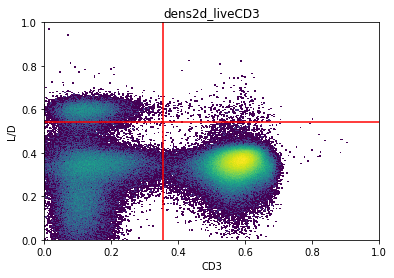

In [107]:
audited_apply(hc, 'dens2d_liveCD3', 'manual_liveCD3', save=False)

In [115]:
for x in samples:
    print(f'Performing gate comparisons for {x}...')
    hc = Gating(exp, x)
    
    print('mixture models...')
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_liveCD3', definition='+')
    child_populations.add_population('gmm_liveCD3_NEG', definition='-')
    gate_definition = dict(x='CD3', y='L/D', target=(0.6, 0.4), k=3, conf=0.99)
    hc.create_gate(gate_name='gmm_liveCD3', parent='lymphocytes', class_='MixtureModel', method='gate',
                    kwargs=gate_definition, child_populations=child_populations)
    audited_apply(hc, 'gmm_liveCD3', 'manual_liveCD3', save=True, plot=False)
    
    print('dbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_liveCD3', target=(0.6, 0.4), weight=1)
    gate_definition = dict(x='CD3', y='L/D', min_pop_size=100, distance_nn=0.01, frac=0.05,nn=10)
    hc.create_gate(gate_name='dbscan_liveCD3', parent='lymphocytes', class_='DensityBasedClustering', method='dbscan',
                    kwargs=gate_definition, child_populations=child_populations)
    audited_apply(hc, 'dbscan_liveCD3', 'manual_liveCD3', save=True, plot=False)
    
    print('hdbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_liveCD3', target=(0.6, 0.4), weight=1)
    gate_definition = dict(x='CD3', y='L/D', min_pop_size=100, frac=0.05)
    hc.create_gate(gate_name='hdbscan_liveCD3', parent='lymphocytes', class_='DensityBasedClustering', 
                     method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    audited_apply(hc, 'hdbscan_liveCD3', 'manual_liveCD3', save=True, plot=False)
    
    print('2D density threshold...')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_liveCD3', definition=['+-'])
    child_populations.add_population('dens2d_liveCD3_Neg', definition=['++', '--', '-+'])
    gate_definition = dict(x='CD3', y='L/D', kde_bw=0.05, peak_threshold=0.05)
    hc.create_gate(gate_name='dens2d_liveCD3', parent='lymphocytes', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    audited_apply(hc, 'dens2d_liveCD3', 'manual_liveCD3', save=True, plot=False)
    
    hc.save(overwrite=True)
    print('---------------------------------------')

Performing gate comparisons for hc1...
mixture models...
dbscan...
hdbscan...
2D density threshold...
Saved successfully!
---------------------------------------
Performing gate comparisons for hc4...
mixture models...
dbscan...
Expected 1 populations, identified 2; {0, 1, -1}
hdbscan...
2D density threshold...
Saved successfully!
---------------------------------------
Performing gate comparisons for hc5...
mixture models...
dbscan...
Expected 1 populations, identified 2; {0, 1, -1}
hdbscan...
2D density threshold...
Saved successfully!
---------------------------------------
Performing gate comparisons for hc7...
mixture models...
dbscan...
Expected 1 populations, identified 2; {0, 1, -1}
hdbscan...
2D density threshold...
Saved successfully!
---------------------------------------
Performing gate comparisons for hc9...
mixture models...
dbscan...
Expected 1 populations, identified 2; {0, 1, -1}
hdbscan...
2D density threshold...
Saved successfully!
----------------------------------

<h2>Results</h2>

In [25]:
gating_performance = pd.read_csv('cd3live_performance.csv')

In [26]:
import seaborn as sns

In [27]:
def rename_method(x):
    if x == 'gmm_liveCD3':
        return 'Gaussian Mixture Model'
    if x == 'dbscan_liveCD3':
        return 'DBSCAN'
    if x == 'hdbscan_liveCD3':
        return 'HDBSCAN'
    if x == 'dens2d_liveCD3':
        return 'Density threshold (2D)'
    return x
gating_performance['method'] = gating_performance['method'].apply(rename_method)

In [5]:
hc = Gating(exp, 'hc1')

Continuing with blank Gating object. Check that populations have not been removed.


In [10]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_liveCD3', target=(0.6, 0.4), weight=1)
gate_definition = dict(x='CD3', y='L/D', min_pop_size=100, frac=0.05)
hc.create_gate(gate_name='hdbscan_liveCD3', parent='lymphocytes', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

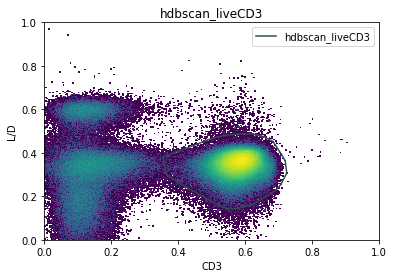

In [11]:
hc.apply('hdbscan_liveCD3')

In [22]:
data = apply_transform(hc.get_population_df('lymphocytes'), ['CD3', 'L/D'], 'logicle')
auto_geom = hc.populations['hdbscan_liveCD3'].geom
x1 = auto_geom['cords']['x']
y1 = auto_geom['cords']['y']

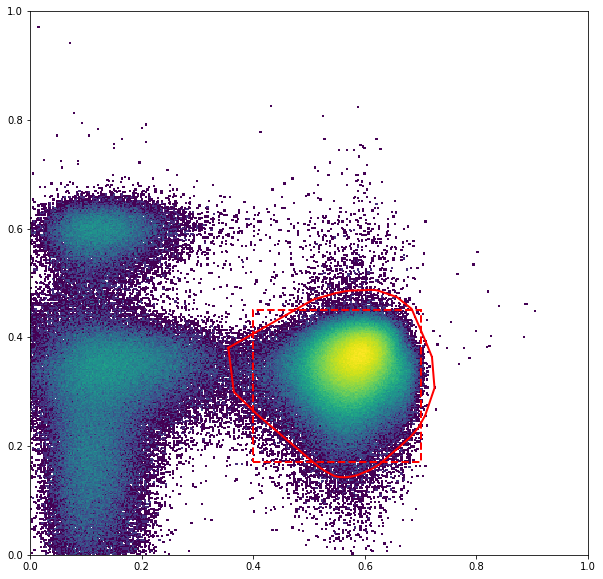

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d(data['CD3'], data['L/D'], bins=500, norm=LogNorm(), cmap='viridis')
manual_rect = Rectangle(xy=(0.4, 0.17), width=0.3, height=0.28, fill=None, color='r', linestyle='--', linewidth=2)
ax.add_patch(manual_rect)
ax.plot(x1, y1, '-k', c='r', linewidth=2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
fig.show()


(0, 1.01)

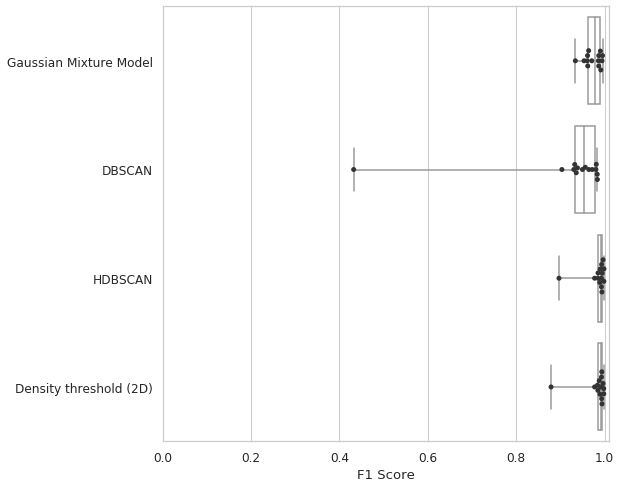

In [29]:
sns.set(font_scale=1.1)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.boxplot(x="f1_score", y="method", data=gating_performance, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=gating_performance, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')
ax.set_xlim(0, 1.01)

Text(0, 0.5, '')

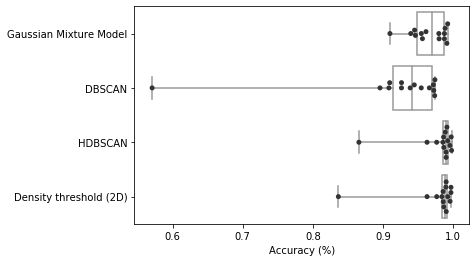

In [119]:
ax = sns.boxplot(x="accuracy", y="method", data=gating_performance, whis=np.inf, color='white')
ax = sns.swarmplot(x="accuracy", y="method", data=gating_performance, color=".2")
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('')

Text(0, 0.5, '')

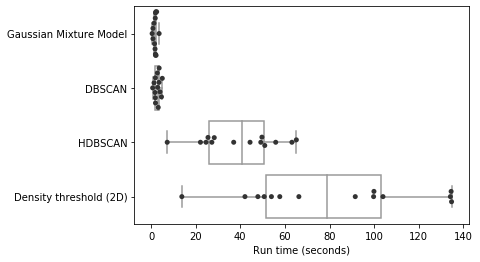

In [120]:
ax = sns.boxplot(x="time", y="method", data=gating_performance, whis=np.inf, color='white')
ax = sns.swarmplot(x="time", y="method", data=gating_performance, color=".2")
ax.set_xlabel('Run time (seconds)')
ax.set_ylabel('')

Text(0, 0.5, '')

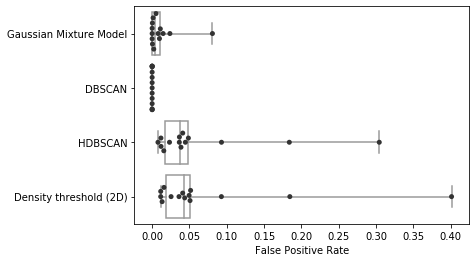

In [121]:
ax = sns.boxplot(x="FPR", y="method", data=gating_performance, whis=np.inf, color='white')
ax = sns.swarmplot(x="FPR", y="method", data=gating_performance, color=".2")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('')

Text(0, 0.5, '')

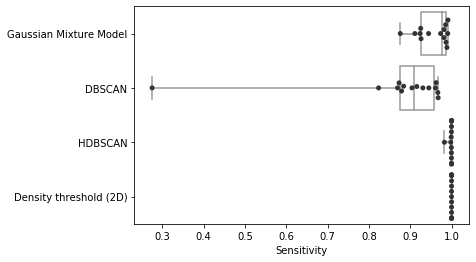

In [122]:
ax = sns.boxplot(x="recall", y="method", data=gating_performance, whis=np.inf, color='white')
ax = sns.swarmplot(x="recall", y="method", data=gating_performance, color=".2")
ax.set_xlabel('Sensitivity')
ax.set_ylabel('')

In [123]:
gating_performance['specificity'] = 1 - gating_performance['FPR']

Text(0, 0.5, '')

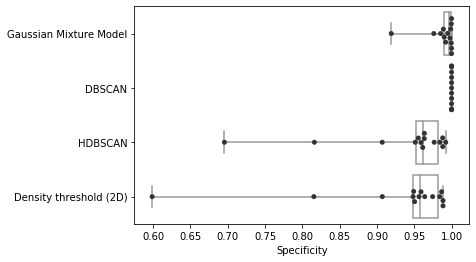

In [124]:
ax = sns.boxplot(x="specificity", y="method", data=gating_performance, whis=np.inf, color='white')
ax = sns.swarmplot(x="specificity", y="method", data=gating_performance, color=".2")
ax.set_xlabel('Specificity')
ax.set_ylabel('')

In [6]:
hc = Gating(exp, 'hc1')

In [7]:
hc.populations.keys()

dict_keys(['root', 'cells', 'debris', 'lymphocytes', 'other_cells', 'manual_liveCD3', 'manual_liveCD3_Neg', 'gmm_liveCD3', 'gmm_liveCD3_NEG', 'dbscan_liveCD3', 'hdbscan_liveCD3', 'dens2d_liveCD3', 'dens2d_liveCD3_Neg', 'gmm_gdt', 'gmm_gdtNEG', 'gmm_nongdt', 'gmm_nongdtNEG', 'gmm_vd2Neg', 'gmm_vd2NegNEG', 'hdbscan_gdt', 'hdbscan_nongdt', 'hdbscan_vd2', 'dens2d_gdt', 'dens2d_nongdt', 'dens2d_vd2', 'dens2d_noise', 'dbscan_cells', 'dbscan_debris', 'dbscan_gdt', 'dbscan_nongdt', 'dbscan_vd2', 'manual_gdt', 'manual_gdtNEG', 'manual_vd2Neg', 'manual_vd2NegNEG', 'manual_nongdt', 'manual_nongdtNEG', 'gmm_lymphocytes', 'gmm_lymphocytes_NEG', 'dbscan_lymphocytes', 'hdbscan_lymphocytes', 'dens2d_lymphocytes', 'dens2d_lymphocytes_NEG', 'manual_lymphocytes', 'manual_lymphocytes_NEG'])

In [8]:
hc.gates.keys()

dict_keys(['gmm_gdt', 'gmm_nongdt', 'gmm_vd2Neg', 'hdbscan_gdt', 'dens2d_gdt', 'dbscan_debris_gate', 'dbscan_gdt', 'manual_gdt', 'manual_vd2Neg', 'manual_nongdt', 'gmm_lymphocytes', 'dbscan_lymphocytes', 'hdbscan_lymphocytes', 'dens2d_lymphocytes', 'manual_lymphocytes'])

In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
gating_performance = dict(sample_id=[], population=[], method=[], accuracy=[], f1_score=[],
                         precision=[], recall=[], fpr=[])

def check_performance(hc, manual_pop, auto_pop, method):
    parent = hc.get_population_df(hc.gates[method].parent)
    manual_pop_idx = hc.populations[manual_pop].index
    auto_pop_idx = hc.populations[auto_pop].index
    # Apply function and measure time taken
    gating_performance['sample_id'].append(hc.id)
    if manual_pop == 'lymphocytes':
        gating_performance['populations'].append('lymphocytes')
    else:
        gating_performance['population'].append(manual_pop.split('_')[1])
    gating_performance['method'].append(method)
    
    #Pull data
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop_idx), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(auto_pop_idx), 1)
    
    # Rate performance of result
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    gating_performance['f1_score'].append(f1)
    gating_performance['accuracy'].append(accuracy)
    gating_performance['precision'].append(precision)
    gating_performance['recall'].append(recall)
    tn, fp, fn, tp = confusion_matrix(y_pred=parent['auto'], y_true=parent['manual']).ravel()
    gating_performance['fpr'].append(fp/(fp+tn))

In [11]:
for x in samples:
    print(f'Assessing performance for {x}')
    hc = Gating(exp, x)
    for method in ['gmm', 'dbscan', 'hdbscan', 'dens2d']:
        auto_pop = f'{method}_liveCD3'
        check_performance(hc, 'manual_liveCD3', auto_pop, auto_pop)

Assessing performance for hc1


KeyError: 'gmm_liveCD3'